# ResNet-Based mmFace

In [3]:
import torch
import torch.nn as nn
# from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_classes = 21

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=2)
        self.fc1 = nn.Linear(512*4*2, 512)
        # self.fc2 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, stride, downsample)] + [block(planes, planes) for _ in range(blocks-1)]
        self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # TODO: MAYBE STOP HERE FOR 512D EMBEDDING???
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        # x = self.fc2(x)
        x = self.fc2(x)

        return x

class MMFace(nn.Module):
    def __init__(self, num_classes=50):
        super(MMFace, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.maxpool =  nn.MaxPool2d(kernel_size=3)
        self.fc = nn.Sequential(
            nn.Linear(64*8*3, 32),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        # Flatten 64 x 8 x 3 to 1536 vector
        x = x.reshape(-1, 64*8*3)
        x = self.fc(x)
        x = self.fc2(x)

        return x

cuda


## Loading Dataset and Model

In [4]:
from dataset_builder import normalise, load_dataset_DL, load_dataset
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np

def load_model(name, model, optimiser):
    epoch = 0
    loss_history, train_acc, val_acc = [], [], []
    try:
        checkpoint = torch.load(f"models/{name}")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        loss_history = checkpoint["loss_history"]
        train_acc = checkpoint["train_acc"]
        val_acc = checkpoint["val_acc"]
    except Exception as ex:
        print(ex)
    
    return epoch, loss_history, train_acc, val_acc

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["loss_history"], checkpoint["train_acc"], checkpoint["val_acc"]

frames = 250
# train, validation, test = load_dataset_DL(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), batch_size=128, transform=Compose([normalise, ToTensor()]))
# subjects = np.random.randint(0, num_classes, (4))
train, validation, test = load_dataset(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), batch_size=128)

KeyboardInterrupt: 

## Hyperparameters + Loss + Optimiser

In [ ]:
# from cnn import MMFace_Padding, MMFace

num_epochs = 30
learning_rate = 0.01

# model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)
# model = MMFace(num_classes).to(device)

# model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = "mmFace-resnet50_pretrained.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

# FINETUNING: FREEZE PRETRAINED PARAMETERS FOR FIRST FEW EPOCHS
for param in model.parameters():
    param.requires_grad = True
model = model.to(device)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

mmFace-resnet50_pretrained.pt
	Epoch: 10
	Loss: 3.0680
	Train Accuracy: 4.7908
	Validation Accuracy: 4.9143


In [1]:
from dataset_builder import load_experiments

load_experiments(250, 0, [0, 1, 3], "test", 'cuda')

375
25
torch.Size([3, 32, 16])
(75, 3, 32, 16)


tensor([[[[1.2200e-06, 1.1764e-06, 6.4100e-07,  ..., 1.2669e-06,
           6.4100e-07, 1.1764e-06],
          [1.9590e-02, 1.8051e-02, 4.7558e-03,  ..., 1.4263e-02,
           2.0017e-02, 1.9935e-02],
          [1.5890e-02, 2.1579e-02, 1.0865e-02,  ..., 1.3166e-02,
           1.1434e-02, 1.0507e-02],
          ...,
          [1.7697e-02, 2.4309e-02, 2.3418e-02,  ..., 1.0865e-02,
           1.1535e-02, 4.2570e-03],
          [1.3092e-02, 1.6517e-02, 1.7078e-02,  ..., 1.2654e-02,
           1.7800e-02, 1.2192e-02],
          [8.6395e-03, 1.4797e-03, 8.4332e-03,  ..., 1.0322e-02,
           1.9019e-02, 1.6514e-02]],

         [[1.0040e-06, 1.0181e-06, 5.3158e-07,  ..., 3.5851e-07,
           5.3158e-07, 1.0181e-06],
          [9.3201e-03, 8.9075e-03, 1.2976e-02,  ..., 7.2006e-03,
           8.7067e-03, 3.6392e-03],
          [1.8984e-03, 1.0631e-02, 6.2743e-03,  ..., 8.0351e-03,
           9.0438e-03, 1.2431e-02],
          ...,
          [6.2037e-03, 1.3195e-02, 1.7999e-02,  ..., 1.1714

## Training
- Load training data in ***batches*** for every epoch, moving to `device`
  - `train_loader` = `[([data*], [labels*])*]`
- `model(data)` to predict label, then calculate loss between predictions and ground truth labels using `criterion(preds, labels)`
- Backpropagate to learn with `loss.backward()`, and update weights with `optimiser.step()`. Gradients must be reset to 0 after every update with `optimiser.zero_grad()` otherwise gradients will accumulate (default PyTorch).
- After every epoch, test model on validation set but can turn off gradients for faster evaluation using `with torch.no_grad()`.

In [ ]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")


Epoch [10/29]:


100%|██████████| 493/493 [01:29<00:00,  5.52it/s]


	Average Train Loss: 2.9300
	Train Accuracy: 8.8879%
	Validation Accuracy: 10.7937%

Epoch [11/29]:


100%|██████████| 493/493 [01:26<00:00,  5.69it/s]


	Average Train Loss: 2.8457
	Train Accuracy: 11.6404%
	Validation Accuracy: 11.9111%

Epoch [12/29]:


100%|██████████| 493/493 [01:28<00:00,  5.56it/s]


	Average Train Loss: 2.7976
	Train Accuracy: 13.0818%
	Validation Accuracy: 12.3810%

Epoch [13/29]:


100%|██████████| 493/493 [01:31<00:00,  5.42it/s]


	Average Train Loss: 2.7575
	Train Accuracy: 14.2993%
	Validation Accuracy: 12.2921%

Epoch [14/29]:


100%|██████████| 493/493 [01:31<00:00,  5.39it/s]


	Average Train Loss: 2.7141
	Train Accuracy: 15.6931%
	Validation Accuracy: 12.3937%

Epoch [15/29]:


100%|██████████| 493/493 [01:31<00:00,  5.41it/s]


	Average Train Loss: 2.6749
	Train Accuracy: 16.7233%
	Validation Accuracy: 12.2032%

Epoch [16/29]:


100%|██████████| 493/493 [01:33<00:00,  5.29it/s]


	Average Train Loss: 2.6070
	Train Accuracy: 19.1203%
	Validation Accuracy: 11.7333%

Epoch [17/29]:


100%|██████████| 493/493 [01:32<00:00,  5.33it/s]


	Average Train Loss: 2.5471
	Train Accuracy: 21.0871%
	Validation Accuracy: 11.1619%

Epoch [18/29]:


100%|██████████| 493/493 [01:31<00:00,  5.39it/s]


	Average Train Loss: 2.4835
	Train Accuracy: 23.2935%
	Validation Accuracy: 12.0762%

Epoch [19/29]:


100%|██████████| 493/493 [01:31<00:00,  5.39it/s]


	Average Train Loss: 2.3994
	Train Accuracy: 26.0207%
	Validation Accuracy: 11.4413%

Epoch [20/29]:


100%|██████████| 493/493 [01:32<00:00,  5.31it/s]


	Average Train Loss: 2.3134
	Train Accuracy: 28.6828%
	Validation Accuracy: 11.4286%

Epoch [21/29]:


100%|██████████| 493/493 [01:33<00:00,  5.28it/s]


	Average Train Loss: 2.2097
	Train Accuracy: 31.8147%
	Validation Accuracy: 11.5556%

Epoch [22/29]:


100%|██████████| 493/493 [01:32<00:00,  5.31it/s]


	Average Train Loss: 2.1014
	Train Accuracy: 35.4657%
	Validation Accuracy: 10.7048%

Epoch [23/29]:


100%|██████████| 493/493 [01:32<00:00,  5.30it/s]


	Average Train Loss: 1.9843
	Train Accuracy: 39.2930%
	Validation Accuracy: 11.3397%

Epoch [24/29]:


100%|██████████| 493/493 [01:34<00:00,  5.20it/s]


	Average Train Loss: 1.8753
	Train Accuracy: 42.7773%
	Validation Accuracy: 11.6063%

Epoch [25/29]:


100%|██████████| 493/493 [01:33<00:00,  5.29it/s]


	Average Train Loss: 1.7524
	Train Accuracy: 46.4585%
	Validation Accuracy: 11.3016%

Epoch [26/29]:


100%|██████████| 493/493 [01:32<00:00,  5.32it/s]


	Average Train Loss: 1.6389
	Train Accuracy: 49.9063%
	Validation Accuracy: 11.3397%

Epoch [27/29]:


100%|██████████| 493/493 [01:31<00:00,  5.38it/s]


	Average Train Loss: 1.5134
	Train Accuracy: 53.7860%
	Validation Accuracy: 10.9714%

Epoch [28/29]:


100%|██████████| 493/493 [01:31<00:00,  5.37it/s]


	Average Train Loss: 1.4379
	Train Accuracy: 56.0591%
	Validation Accuracy: 11.0603%

Epoch [29/29]:


100%|██████████| 493/493 [01:31<00:00,  5.37it/s]


	Average Train Loss: 1.3428
	Train Accuracy: 59.1006%
	Validation Accuracy: 10.9841%


## Testing

In [ ]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 10.5524%


# Evaluation

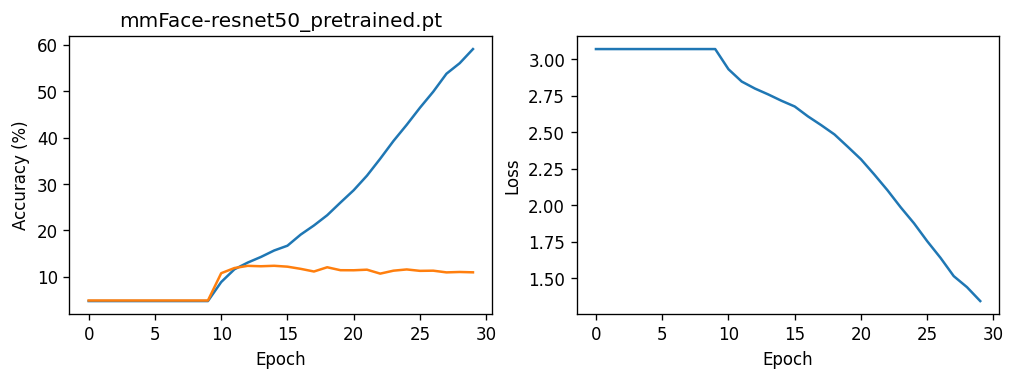

In [ ]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

[Text(0.5, 25.222222222222214, 'Predictions'),
 Text(145.22222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

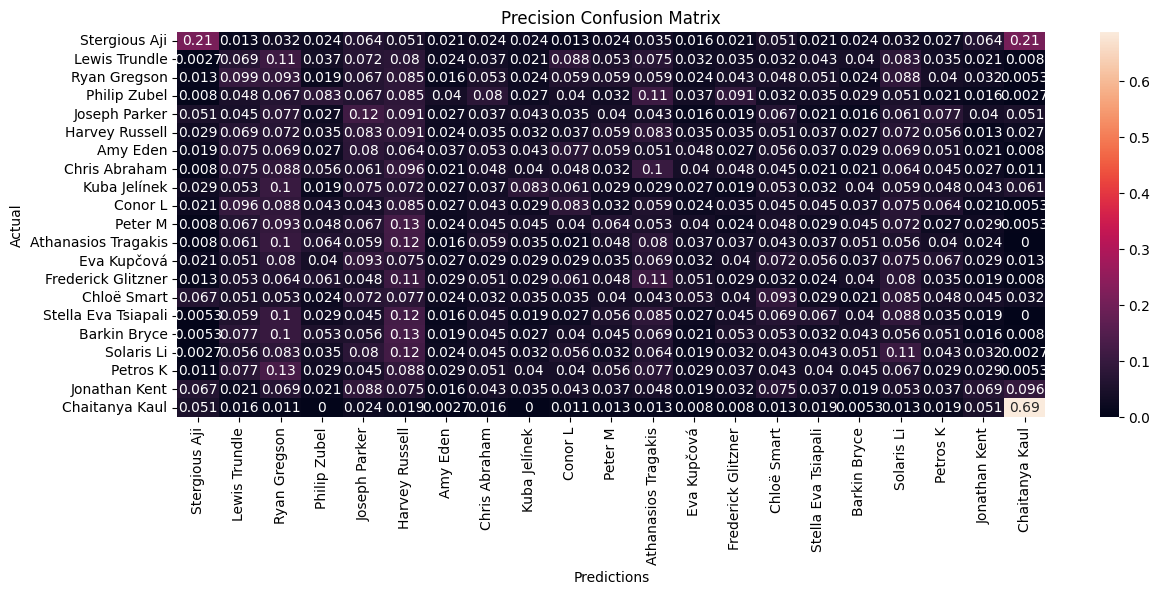

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subjects = anon_names
# subjects = range(num_classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subjects, columns=subjects)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')